In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import cv2
import os

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from tensorflow.keras.models import Model

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
import scikitplot as skplt

import pickle
import dill

In [3]:
# filepath = 'session.pkl'
# dill.dump_session(filepath) # Save the session

In [4]:
info = pd.read_csv('data/info.csv', header=None)

In [5]:
# 20 annotation scores per frame for each video 
# each row is a new set of annotation scores of each video, with 20 rows per video
# scores are from 1-5
# 2 second long shot-level importance scores
annotations = pd.read_csv('data/annotations.csv', header=None)

In [6]:
# 20 videos
# 5 videos per category

# VT: Changing Vehicle Tire
# VU: Getting Vehicle Unstuck
# GA: Grooming an Animal
# MS: Making Sandwich
# PK: Parkour
# PR: Parade
# FM: Flash Mob Gathering
# BK: Bee Keeping
# BT: Attempting Bike Tricks
# DS: Dog Show

info = pd.read_csv('data/info.csv')

In [7]:
annotations.rename(columns={0: 'filename', 1: 'category', 2: 'annotations'}, inplace=True)

In [8]:
annotations.head()

,filename,category,annotations
0,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
1,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."
2,AwmHb44_ouw,VT,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,..."
3,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
4,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."


In [9]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
filename       1000 non-null object
category       1000 non-null object
annotations    1000 non-null object
dtypes: object(3)
memory usage: 23.6+ KB


In [10]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [11]:
annotations['annotations'] = annotations['annotations'].apply(lambda a: a.split(','))

In [12]:
avg_annotations = []
for fname in annotations.filename.unique():
    values = annotations[annotations['filename'] == fname]['annotations'].values
    float_conversion = np.array(list(values)).astype('float64') 
    avg = np.mean(float_conversion, axis=0)
    avg_annotations.append(avg)

In [13]:
average_scores = pd.DataFrame({'filename': annotations.filename.unique(), 'average_score': avg_annotations})

In [14]:
average_scores.sort_values(by='filename')

,filename,average_score
49,-esJrBWj2d8,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
12,0tmA_C6XwfM,"[1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.1..."
18,37rzWOQsNIw,"[3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.2..."
13,3eYKfiOEJNs,"[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ..."
29,4wU_LUjG5Ic,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
25,91IHQYk1IQM,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."
1,98MoyGZKHXc,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
0,AwmHb44_ouw,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
11,Bhxk-O1Y7Ho,"[2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.9..."
45,E11zDS9XGzg,"[1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.6..."


In [15]:
info.columns

Index(['category', 'video_id', 'title', 'url', 'length'], dtype='object')

In [16]:
info[info['video_id'] == '-esJrBWj2d8']

,category,video_id,title,url,length
49,DS,-esJrBWj2d8,Will A Cat Eat Dog Food?,https://www.youtube.com/watch?v=-esJrBWj2d8,3:50


In [17]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [18]:
full_df = pd.concat([info.set_index('video_id'), average_scores.set_index('filename')], axis=1, join='inner')

In [19]:
full_df = full_df.reset_index().rename(columns={'index': 'video_id'})

In [20]:
full_df

,video_id,category,title,url,length,average_score
0,AwmHb44_ouw,VT,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
1,98MoyGZKHXc,VT,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
2,J0nA4VgnoCo,VT,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."
3,gzDbaEs1Rlg,VT,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48,"[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ..."
4,XzYM3PfTM4w,VT,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."
5,HT5vyqe0Xaw,VU,"The stuck truck of Mark, The rut that filled a...",https://www.youtube.com/watch?v=HT5vyqe0Xaw,5:22,"[1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25, 1.2..."
6,sTEELN-vY30,VU,BBC - Train crash 2013,https://www.youtube.com/watch?v=sTEELN-vY30,2:29,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
7,vdmoEJ5YbrQ,VU,#453 girl gets van stuck in the back fourty [D...,https://www.youtube.com/watch?v=vdmoEJ5YbrQ,5:29,"[2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, 2.2, ..."
8,xwqBXPGE9pQ,VU,Smart Electric Vehicle Balances on Two Wheels,https://www.youtube.com/watch?v=xwqBXPGE9pQ,3:53,"[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, ..."
9,akI8YFjEmUw,VU,Electric cars making earth more green,https://www.youtube.com/watch?v=akI8YFjEmUw,2:13,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."


In [21]:
avg_scores_sample = full_df[full_df['video_id'] == 'akI8YFjEmUw']['average_score'].values[0]

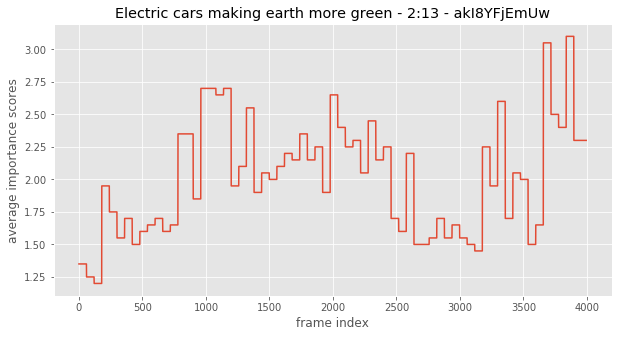

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(avg_scores_sample))
ax.set_xlabel('frame index')
ax.set_ylabel('average importance scores')
ax.set_title('Electric cars making earth more green - 2:13 - akI8YFjEmUw')
ax.plot(x, avg_scores_sample)

In [23]:
def plot_average_importance_scores(avg_scores, title):
  fig, ax = plt.subplots(figsize=(10, 5))
  x = range(len(avg_scores))
  ax.set_xlabel('frame index')
  ax.set_ylabel('average importance scores')
  ax.set_title(title)
  ax.plot(x, avg_scores)

In [24]:
def sort_frames(list_of_frames, video_id, data_set='train'):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/{data_set}/{video_id}/')[1].split('.jpg')[0]))

In [25]:
def rgb_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [26]:
def hsv_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [27]:
def get_vgg_features(image_list):
  image_features = []
  base_model = VGG16(weights='imagenet', include_top=False)
  model = Model(inputs=base_model.input,
                outputs=base_model.get_layer('block5_conv3').output)

  for idx, frame in enumerate(image_list):
    img = image.load_img(frame, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model.predict(img_data)
    image_features.append(np.array(vgg16_feature).flatten())
    print(f'complete for {idx}')

  return image_features

In [28]:
def create_train_or_test_data_set_for_rgb(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = rgb_features(sorted_frames, 8)
      else:
          X = np.concatenate(
              (X, rgb_features(sorted_frames, 8)), axis=0)
      scores = average_scores[average_scores['filename'] ==
                              video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X, y

In [29]:
def create_train_or_test_data_set_for_hsv(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = hsv_features(sorted_frames, 8)
      else:
          X = np.concatenate(
              (X, rgb_features(sorted_frames, 8)), axis=0)
      scores = average_scores[average_scores['filename'] == video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X, y

In [30]:
def sort_frames(list_of_frames, video_id, data_set='train'):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/{data_set}/{video_id}/')[1].split('.jpg')[0]))

In [42]:
def create_data_set_for_vgg(data_set='train'):
  X = 'first'
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      frames = glob.glob(f'{directory}/*')
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      sorted_frames = sort_frames(frames, video_id, data_set=data_set)
      if X == 'first':
          X = get_vgg_features(sorted_frames)
      else:
          X = np.concatenate((X, get_vgg_features(sorted_frames)))
      print(f'complete for {video_id}')
      print(np.array(X).shape, np.array(y).shape)
  X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
  return X

In [ ]:
def create_y_data(data_set='train'):
  y = 'first'
  for directory in glob.glob(f'data/frames/{data_set}/*'):
      video_id = directory.split(f'data/frames/{data_set}/')[1]
      scores = average_scores[average_scores['filename'] ==
                              video_id]['average_score'].values[0].reshape(-1, 1)
      if y == 'first':
          y = scores
      else:
          y = np.concatenate((y, scores), axis=0)
      print(f'complete for {video_id}')
      print(np.array(y).shape)
  return y

In [39]:
for directory in glob.glob(f'data/frames/train_bike_tricks/*'):
    video_id = directory.split(f'data/frames/train_bike_tricks/')[1]
    print(full_df[full_df['video_id'] == video_id]['video_id'].values[0], full_df[full_df['video_id'] == video_id]['title'].values[0])

eQu1rNs0an0 How to stop your Fixie
EYqVtI9YWJA Smage Bros. Motorcycle Stunt Show
JgHubY5Vw3Y How to lock your bike. The RIGHT way!
iVt07TCkFM0 Pure Fix TV: How to Wheelie


In [40]:
for directory in glob.glob(f'data/frames/test_bike_tricks/*'):
    video_id = directory.split(f'data/frames/test_bike_tricks/')[1]
    print(full_df[full_df['video_id'] == video_id]['video_id'].values[0], full_df[full_df['video_id'] == video_id]['title'].values[0])

qqR6AEXwxoQ Motocross Tips & Tricks : How to Whip a Motocross Bike


In [44]:
X_train_bike_tricks = create_data_set_for_vgg(data_set='train_bike_tricks')

complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 5

complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
com

complete for 1428
complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete f

complete for 1884
complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete f

complete for 2340
complete for 2341
complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete f

complete for 2796
complete for 2797
complete for 2798
complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete f

complete for 3252
complete for 3253
complete for 3254
complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete f

complete for 3709
complete for 3710
complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete f

complete for 4165
complete for 4166
complete for 4167
complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete f

complete for 4621
complete for 4622
complete for 4623
complete for 4624
complete for 4625
complete for 4626
complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete for 4641
complete for 4642
complete for 4643
complete for 4644
complete for 4645
complete for 4646
complete for 4647
complete for 4648
complete for 4649
complete for 4650
complete for 4651
complete for 4652
complete for 4653
complete for 4654
complete for 4655
complete for 4656
complete for 4657
complete for 4658
complete for 4659
complete for 4660
complete for 4661
complete for 4662
complete for 4663
complete for 4664
complete for 4665
complete for 4666
complete for 4667
complete for 4668
complete for 4669
complete for 4670
complete for 4671
complete for 4672
complete for 4673
complete for 4674
complete for 4675
complete f

complete for 158
complete for 159
complete for 160
complete for 161
complete for 162
complete for 163
complete for 164
complete for 165
complete for 166
complete for 167
complete for 168
complete for 169
complete for 170
complete for 171
complete for 172
complete for 173
complete for 174
complete for 175
complete for 176
complete for 177
complete for 178
complete for 179
complete for 180
complete for 181
complete for 182
complete for 183
complete for 184
complete for 185
complete for 186
complete for 187
complete for 188
complete for 189
complete for 190
complete for 191
complete for 192
complete for 193
complete for 194
complete for 195
complete for 196
complete for 197
complete for 198
complete for 199
complete for 200
complete for 201
complete for 202
complete for 203
complete for 204
complete for 205
complete for 206
complete for 207
complete for 208
complete for 209
complete for 210
complete for 211
complete for 212
complete for 213
complete for 214
complete for 215
complete for 2

complete for 640
complete for 641
complete for 642
complete for 643
complete for 644
complete for 645
complete for 646
complete for 647
complete for 648
complete for 649
complete for 650
complete for 651
complete for 652
complete for 653
complete for 654
complete for 655
complete for 656
complete for 657
complete for 658
complete for 659
complete for 660
complete for 661
complete for 662
complete for 663
complete for 664
complete for 665
complete for 666
complete for 667
complete for 668
complete for 669
complete for 670
complete for 671
complete for 672
complete for 673
complete for 674
complete for 675
complete for 676
complete for 677
complete for 678
complete for 679
complete for 680
complete for 681
complete for 682
complete for 683
complete for 684
complete for 685
complete for 686
complete for 687
complete for 688
complete for 689
complete for 690
complete for 691
complete for 692
complete for 693
complete for 694
complete for 695
complete for 696
complete for 697
complete for 6

complete for 1116
complete for 1117
complete for 1118
complete for 1119
complete for 1120
complete for 1121
complete for 1122
complete for 1123
complete for 1124
complete for 1125
complete for 1126
complete for 1127
complete for 1128
complete for 1129
complete for 1130
complete for 1131
complete for 1132
complete for 1133
complete for 1134
complete for 1135
complete for 1136
complete for 1137
complete for 1138
complete for 1139
complete for 1140
complete for 1141
complete for 1142
complete for 1143
complete for 1144
complete for 1145
complete for 1146
complete for 1147
complete for 1148
complete for 1149
complete for 1150
complete for 1151
complete for 1152
complete for 1153
complete for 1154
complete for 1155
complete for 1156
complete for 1157
complete for 1158
complete for 1159
complete for 1160
complete for 1161
complete for 1162
complete for 1163
complete for 1164
complete for 1165
complete for 1166
complete for 1167
complete for 1168
complete for 1169
complete for 1170
complete f

complete for 1572
complete for 1573
complete for 1574
complete for 1575
complete for 1576
complete for 1577
complete for 1578
complete for 1579
complete for 1580
complete for 1581
complete for 1582
complete for 1583
complete for 1584
complete for 1585
complete for 1586
complete for 1587
complete for 1588
complete for 1589
complete for 1590
complete for 1591
complete for 1592
complete for 1593
complete for 1594
complete for 1595
complete for 1596
complete for 1597
complete for 1598
complete for 1599
complete for 1600
complete for 1601
complete for 1602
complete for 1603
complete for 1604
complete for 1605
complete for 1606
complete for 1607
complete for 1608
complete for 1609
complete for 1610
complete for 1611
complete for 1612
complete for 1613
complete for 1614
complete for 1615
complete for 1616
complete for 1617
complete for 1618
complete for 1619
complete for 1620
complete for 1621
complete for 1622
complete for 1623
complete for 1624
complete for 1625
complete for 1626
complete f

complete for 2028
complete for 2029
complete for 2030
complete for 2031
complete for 2032
complete for 2033
complete for 2034
complete for 2035
complete for 2036
complete for 2037
complete for 2038
complete for 2039
complete for 2040
complete for 2041
complete for 2042
complete for 2043
complete for 2044
complete for 2045
complete for 2046
complete for 2047
complete for 2048
complete for 2049
complete for 2050
complete for 2051
complete for 2052
complete for 2053
complete for 2054
complete for 2055
complete for 2056
complete for 2057
complete for 2058
complete for 2059
complete for 2060
complete for 2061
complete for 2062
complete for 2063
complete for 2064
complete for 2065
complete for 2066
complete for 2067
complete for 2068
complete for 2069
complete for 2070
complete for 2071
complete for 2072
complete for 2073
complete for 2074
complete for 2075
complete for 2076
complete for 2077
complete for 2078
complete for 2079
complete for 2080
complete for 2081
complete for 2082
complete f

complete for 2484
complete for 2485
complete for 2486
complete for 2487
complete for 2488
complete for 2489
complete for 2490
complete for 2491
complete for 2492
complete for 2493
complete for 2494
complete for 2495
complete for 2496
complete for 2497
complete for 2498
complete for 2499
complete for 2500
complete for 2501
complete for 2502
complete for 2503
complete for 2504
complete for 2505
complete for 2506
complete for 2507
complete for 2508
complete for 2509
complete for 2510
complete for 2511
complete for 2512
complete for 2513
complete for 2514
complete for 2515
complete for 2516
complete for 2517
complete for 2518
complete for 2519
complete for 2520
complete for 2521
complete for 2522
complete for 2523
complete for 2524
complete for 2525
complete for 2526
complete for 2527
complete for 2528
complete for 2529
complete for 2530
complete for 2531
complete for 2532
complete for 2533
complete for 2534
complete for 2535
complete for 2536
complete for 2537
complete for 2538
complete f

complete for 2940
complete for 2941
complete for 2942
complete for 2943
complete for 2944
complete for 2945
complete for 2946
complete for 2947
complete for 2948
complete for 2949
complete for 2950
complete for 2951
complete for 2952
complete for 2953
complete for 2954
complete for 2955
complete for 2956
complete for 2957
complete for 2958
complete for 2959
complete for 2960
complete for 2961
complete for 2962
complete for 2963
complete for 2964
complete for 2965
complete for 2966
complete for 2967
complete for 2968
complete for 2969
complete for 2970
complete for 2971
complete for 2972
complete for 2973
complete for 2974
complete for 2975
complete for 2976
complete for 2977
complete for 2978
complete for 2979
complete for 2980
complete for 2981
complete for 2982
complete for 2983
complete for 2984
complete for 2985
complete for 2986
complete for 2987
complete for 2988
complete for 2989
complete for 2990
complete for 2991
complete for 2992
complete for 2993
complete for 2994
complete f

complete for 3396
complete for 3397
complete for 3398
complete for 3399
complete for 3400
complete for 3401
complete for 3402
complete for 3403
complete for 3404
complete for 3405
complete for 3406
complete for 3407
complete for 3408
complete for 3409
complete for 3410
complete for 3411
complete for 3412
complete for 3413
complete for 3414
complete for 3415
complete for 3416
complete for 3417
complete for 3418
complete for 3419
complete for 3420
complete for 3421
complete for 3422
complete for 3423
complete for 3424
complete for 3425
complete for 3426
complete for 3427
complete for 3428
complete for 3429
complete for 3430
complete for 3431
complete for 3432
complete for 3433
complete for 3434
complete for 3435
complete for 3436
complete for 3437
complete for 3438
complete for 3439
complete for 3440
complete for 3441
complete for 3442
complete for 3443
complete for 3444
complete for 3445
complete for 3446
complete for 3447
complete for 3448
complete for 3449
complete for 3450
complete f

complete for 3852
complete for 3853
complete for 3854
complete for 3855
complete for 3856
complete for 3857
complete for 3858
complete for 3859
complete for 3860
complete for 3861
complete for 3862
complete for 3863
complete for 3864
complete for 3865
complete for 3866
complete for 3867
complete for 3868
complete for 3869
complete for 3870
complete for 3871
complete for 3872
complete for 3873
complete for 3874
complete for 3875
complete for 3876
complete for 3877
complete for 3878
complete for 3879
complete for 3880
complete for 3881
complete for 3882
complete for 3883
complete for 3884
complete for 3885
complete for 3886
complete for 3887
complete for 3888
complete for 3889
complete for 3890
complete for 3891
complete for 3892
complete for 3893
complete for 3894
complete for 3895
complete for 3896
complete for 3897
complete for 3898
complete for 3899
complete for 3900
complete for 3901
complete for 3902
complete for 3903
complete for 3904
complete for 3905
complete for 3906
complete f

complete for 4308
complete for 4309
complete for 4310
complete for 4311
complete for 4312
complete for 4313
complete for 4314
complete for 4315
complete for 4316
complete for 4317
complete for 4318
complete for 4319
complete for 4320
complete for 4321
complete for 4322
complete for 4323
complete for 4324
complete for 4325
complete for 4326
complete for 4327
complete for 4328
complete for 4329
complete for 4330
complete for 4331
complete for 4332
complete for 4333
complete for 4334
complete for 4335
complete for 4336
complete for 4337
complete for 4338
complete for 4339
complete for 4340
complete for 4341
complete for 4342
complete for 4343
complete for 4344
complete for 4345
complete for 4346
complete for 4347
complete for 4348
complete for 4349
complete for 4350
complete for 4351
complete for 4352
complete for 4353
complete for 4354
complete for 4355
complete for 4356
complete for 4357
complete for 4358
complete for 4359
complete for 4360
complete for 4361
complete for 4362
complete f

complete for 4764
complete for 4765
complete for 4766
complete for 4767
complete for 4768
complete for 4769
complete for 4770
complete for 4771
complete for 4772
complete for 4773
complete for 4774
complete for 4775
complete for 4776
complete for 4777
complete for 4778
complete for 4779
complete for 4780
complete for 4781
complete for 4782
complete for 4783
complete for 4784
complete for 4785
complete for 4786
complete for 4787
complete for 4788
complete for 4789
complete for 4790
complete for 4791
complete for 4792
complete for 4793
complete for 4794
complete for 4795
complete for 4796
complete for 4797
complete for 4798
complete for 4799
complete for 4800
complete for 4801
complete for 4802
complete for 4803
complete for 4804
complete for 4805
complete for 4806
complete for 4807
complete for 4808
complete for 4809
complete for 4810
complete for 4811
complete for 4812
complete for 4813
complete for 4814
complete for 4815
complete for 4816
complete for 4817
complete for 4818
complete f

complete for 5221
complete for 5222
complete for 5223
complete for 5224
complete for 5225
complete for 5226
complete for 5227
complete for 5228
complete for 5229
complete for 5230
complete for 5231
complete for 5232
complete for 5233
complete for 5234
complete for 5235
complete for 5236
complete for 5237
complete for 5238
complete for 5239
complete for 5240
complete for 5241
complete for 5242
complete for 5243
complete for 5244
complete for 5245
complete for 5246
complete for 5247
complete for 5248
complete for 5249
complete for 5250
complete for 5251
complete for 5252
complete for 5253
complete for 5254
complete for 5255
complete for 5256
complete for 5257
complete for 5258
complete for 5259
complete for 5260
complete for 5261
complete for 5262
complete for 5263
complete for 5264
complete for 5265
complete for 5266
complete for 5267
complete for 5268
complete for 5269
complete for 5270
complete for 5271
complete for 5272
complete for 5273
complete for 5274
complete for 5275
complete f

complete for 5677
complete for 5678
complete for 5679
complete for 5680
complete for 5681
complete for 5682
complete for 5683
complete for 5684
complete for 5685
complete for 5686
complete for 5687
complete for 5688
complete for 5689
complete for 5690
complete for 5691
complete for 5692
complete for 5693
complete for 5694
complete for 5695
complete for 5696
complete for 5697
complete for 5698
complete for 5699
complete for 5700
complete for 5701
complete for 5702
complete for 5703
complete for 5704
complete for 5705
complete for 5706
complete for 5707
complete for 5708
complete for 5709
complete for 5710
complete for 5711
complete for 5712
complete for 5713
complete for 5714
complete for 5715
complete for 5716
complete for 5717
complete for 5718
complete for 5719
complete for 5720
complete for 5721
complete for 5722
complete for 5723
complete for 5724
complete for 5725
complete for 5726
complete for 5727
complete for 5728
complete for 5729
complete for 5730
complete for 5731
complete f

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 547
complete for 5

complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
complete for 1029
c

complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete for 1484
complete f

complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete for 1940
complete for 1941
complete f

complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete for 2397
complete f

complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete for 2854
complete f

complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete for 3310
complete for 3311
complete f

complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete for 3767
complete f

complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete for 4223
complete for 4224
complete f

complete for 344
complete for 345
complete for 346
complete for 347
complete for 348
complete for 349
complete for 350
complete for 351
complete for 352
complete for 353
complete for 354
complete for 355
complete for 356
complete for 357
complete for 358
complete for 359
complete for 360
complete for 361
complete for 362
complete for 363
complete for 364
complete for 365
complete for 366
complete for 367
complete for 368
complete for 369
complete for 370
complete for 371
complete for 372
complete for 373
complete for 374
complete for 375
complete for 376
complete for 377
complete for 378
complete for 379
complete for 380
complete for 381
complete for 382
complete for 383
complete for 384
complete for 385
complete for 386
complete for 387
complete for 388
complete for 389
complete for 390
complete for 391
complete for 392
complete for 393
complete for 394
complete for 395
complete for 396
complete for 397
complete for 398
complete for 399
complete for 400
complete for 401
complete for 4

complete for 826
complete for 827
complete for 828
complete for 829
complete for 830
complete for 831
complete for 832
complete for 833
complete for 834
complete for 835
complete for 836
complete for 837
complete for 838
complete for 839
complete for 840
complete for 841
complete for 842
complete for 843
complete for 844
complete for 845
complete for 846
complete for 847
complete for 848
complete for 849
complete for 850
complete for 851
complete for 852
complete for 853
complete for 854
complete for 855
complete for 856
complete for 857
complete for 858
complete for 859
complete for 860
complete for 861
complete for 862
complete for 863
complete for 864
complete for 865
complete for 866
complete for 867
complete for 868
complete for 869
complete for 870
complete for 871
complete for 872
complete for 873
complete for 874
complete for 875
complete for 876
complete for 877
complete for 878
complete for 879
complete for 880
complete for 881
complete for 882
complete for 883
complete for 8

complete for 1291
complete for 1292
complete for 1293
complete for 1294
complete for 1295
complete for 1296
complete for 1297
complete for 1298
complete for 1299
complete for 1300
complete for 1301
complete for 1302
complete for 1303
complete for 1304
complete for 1305
complete for 1306
complete for 1307
complete for 1308
complete for 1309
complete for 1310
complete for 1311
complete for 1312
complete for 1313
complete for 1314
complete for 1315
complete for 1316
complete for 1317
complete for 1318
complete for 1319
complete for 1320
complete for 1321
complete for 1322
complete for 1323
complete for 1324
complete for 1325
complete for 1326
complete for 1327
complete for 1328
complete for 1329
complete for 1330
complete for 1331
complete for 1332
complete for 1333
complete for 1334
complete for 1335
complete for 1336
complete for 1337
complete for 1338
complete for 1339
complete for 1340
complete for 1341
complete for 1342
complete for 1343
complete for 1344
complete for 1345
complete f

complete for 1747
complete for 1748
complete for 1749
complete for 1750
complete for 1751
complete for 1752
complete for 1753
complete for 1754
complete for 1755
complete for 1756
complete for 1757
complete for 1758
complete for 1759
complete for 1760
complete for 1761
complete for 1762
complete for 1763
complete for 1764
complete for 1765
complete for 1766
complete for 1767
complete for 1768
complete for 1769
complete for 1770
complete for 1771
complete for 1772
complete for 1773
complete for 1774
complete for 1775
complete for 1776
complete for 1777
complete for 1778
complete for 1779
complete for 1780
complete for 1781
complete for 1782
complete for 1783
complete for 1784
complete for 1785
complete for 1786
complete for 1787
complete for 1788
complete for 1789
complete for 1790
complete for 1791
complete for 1792
complete for 1793
complete for 1794
complete for 1795
complete for 1796
complete for 1797
complete for 1798
complete for 1799
complete for 1800
complete for 1801
complete f

complete for 2203
complete for 2204
complete for 2205
complete for 2206
complete for 2207
complete for 2208
complete for 2209
complete for 2210
complete for 2211
complete for 2212
complete for 2213
complete for 2214
complete for 2215
complete for 2216
complete for 2217
complete for 2218
complete for 2219
complete for 2220
complete for 2221
complete for 2222
complete for 2223
complete for 2224
complete for 2225
complete for 2226
complete for 2227
complete for 2228
complete for 2229
complete for 2230
complete for 2231
complete for 2232
complete for 2233
complete for 2234
complete for 2235
complete for 2236
complete for 2237
complete for 2238
complete for 2239
complete for 2240
complete for 2241
complete for 2242
complete for 2243
complete for 2244
complete for 2245
complete for 2246
complete for 2247
complete for 2248
complete for 2249
complete for 2250
complete for 2251
complete for 2252
complete for 2253
complete for 2254
complete for 2255
complete for 2256
complete for 2257
complete f

In [45]:
y_train_bike_tricks = create_y_data(data_set='train_bike_tricks')

complete for eQu1rNs0an0
(4931, 1)
complete for EYqVtI9YWJA
(10870, 1)
complete for JgHubY5Vw3Y
(15174, 1)
complete for iVt07TCkFM0
(17674, 1)


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [48]:
X_test_bike_tricks = create_data_set_for_vgg(data_set='test_bike_tricks')

complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 5

complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
com

complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete f

complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete for 1940
complete f

complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete for 2397
complete f

complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete f

complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete for 3310
complete f

complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete for 3767
complete f

complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete for 4223
complete for 4224
complete f

complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete for 4641
complete for 4642
complete for 4643
complete for 4644
complete for 4645
complete for 4646
complete for 4647
complete for 4648
complete for 4649
complete for 4650
complete for 4651
complete for 4652
complete for 4653
complete for 4654
complete for 4655
complete for 4656
complete for 4657
complete for 4658
complete for 4659
complete for 4660
complete for 4661
complete for 4662
complete for 4663
complete for 4664
complete for 4665
complete for 4666
complete for 4667
complete for 4668
complete for 4669
complete for 4670
complete for 4671
complete for 4672
complete for 4673
complete for 4674
complete for 4675
complete for 4676
complete for 4677
complete for 4678
complete for 4679
complete for 4680
complete for 4681
complete f

complete for 5084
complete for 5085
complete for 5086
complete for 5087
complete for 5088
complete for 5089
complete for 5090
complete for 5091
complete for 5092
complete for 5093
complete for 5094
complete for 5095
complete for 5096
complete for 5097
complete for 5098
complete for 5099
complete for 5100
complete for 5101
complete for 5102
complete for 5103
complete for 5104
complete for 5105
complete for 5106
complete for 5107
complete for 5108
complete for 5109
complete for 5110
complete for 5111
complete for 5112
complete for 5113
complete for 5114
complete for 5115
complete for 5116
complete for 5117
complete for 5118
complete for 5119
complete for 5120
complete for 5121
complete for 5122
complete for 5123
complete for 5124
complete for 5125
complete for 5126
complete for 5127
complete for 5128
complete for 5129
complete for 5130
complete for 5131
complete for 5132
complete for 5133
complete for 5134
complete for 5135
complete for 5136
complete for 5137
complete for 5138
complete f

complete for 5540
complete for 5541
complete for 5542
complete for 5543
complete for 5544
complete for 5545
complete for 5546
complete for 5547
complete for 5548
complete for 5549
complete for 5550
complete for 5551
complete for 5552
complete for 5553
complete for 5554
complete for 5555
complete for 5556
complete for 5557
complete for 5558
complete for 5559
complete for 5560
complete for 5561
complete for 5562
complete for 5563
complete for 5564
complete for 5565
complete for 5566
complete for 5567
complete for 5568
complete for 5569
complete for 5570
complete for 5571
complete for 5572
complete for 5573
complete for 5574
complete for 5575
complete for 5576
complete for 5577
complete for 5578
complete for 5579
complete for 5580
complete for 5581
complete for 5582
complete for 5583
complete for 5584
complete for 5585
complete for 5586
complete for 5587
complete for 5588
complete for 5589
complete for 5590
complete for 5591
complete for 5592
complete for 5593
complete for 5594
complete f

complete for 5996
complete for 5997
complete for 5998
complete for 5999
complete for 6000
complete for 6001
complete for 6002
complete for 6003
complete for 6004
complete for 6005
complete for 6006
complete for 6007
complete for 6008
complete for 6009
complete for 6010
complete for 6011
complete for 6012
complete for 6013
complete for 6014
complete for 6015
complete for 6016
complete for 6017
complete for 6018
complete for 6019
complete for 6020
complete for 6021
complete for 6022
complete for 6023
complete for 6024
complete for 6025
complete for 6026
complete for 6027
complete for 6028
complete for 6029
complete for 6030
complete for 6031
complete for 6032
complete for 6033
complete for 6034
complete for 6035
complete for 6036
complete for 6037
complete for 6038
complete for 6039
complete for 6040
complete for 6041
complete for 6042
complete for 6043
complete for 6044
complete for 6045
complete for 6046
complete for 6047
complete for 6048
complete for 6049
complete for 6050
complete f

complete for 6453
complete for 6454
complete for 6455
complete for 6456
complete for 6457
complete for 6458
complete for 6459
complete for 6460
complete for 6461
complete for 6462
complete for 6463
complete for 6464
complete for 6465
complete for 6466
complete for 6467
complete for 6468
complete for 6469
complete for 6470
complete for 6471
complete for 6472
complete for 6473
complete for 6474
complete for 6475
complete for 6476
complete for 6477
complete for 6478
complete for 6479
complete for 6480
complete for 6481
complete for 6482
complete for 6483
complete for 6484
complete for 6485
complete for 6486
complete for 6487
complete for 6488
complete for 6489
complete for 6490
complete for 6491
complete for 6492
complete for 6493
complete for 6494
complete for 6495
complete for 6496
complete for 6497
complete for 6498
complete for 6499
complete for 6500
complete for 6501
complete for 6502
complete for 6503
complete for 6504
complete for 6505
complete for 6506
complete for 6507
complete f

complete for 6910
complete for 6911
complete for 6912
complete for 6913
complete for 6914
complete for 6915
complete for 6916
complete for 6917
complete for 6918
complete for 6919
complete for 6920
complete for 6921
complete for 6922
complete for 6923
complete for 6924
complete for 6925
complete for 6926
complete for 6927
complete for 6928
complete for 6929
complete for 6930
complete for 6931
complete for 6932
complete for 6933
complete for 6934
complete for 6935
complete for 6936
complete for 6937
complete for 6938
complete for 6939
complete for 6940
complete for 6941
complete for 6942
complete for 6943
complete for 6944
complete for 6945
complete for 6946
complete for 6947
complete for 6948
complete for 6949
complete for 6950
complete for 6951
complete for 6952
complete for 6953
complete for 6954
complete for 6955
complete for 6956
complete for 6957
complete for 6958
complete for 6959
complete for 6960
complete for 6961
complete for 6962
complete for 6963
complete for 6964
complete f

complete for 7367
complete for 7368
complete for 7369
complete for 7370
complete for 7371
complete for 7372
complete for 7373
complete for 7374
complete for 7375
complete for 7376
complete for 7377
complete for 7378
complete for 7379
complete for 7380
complete for 7381
complete for 7382
complete for 7383
complete for 7384
complete for 7385
complete for 7386
complete for 7387
complete for 7388
complete for 7389
complete for 7390
complete for 7391
complete for 7392
complete for 7393
complete for 7394
complete for 7395
complete for 7396
complete for 7397
complete for 7398
complete for 7399
complete for 7400
complete for 7401
complete for 7402
complete for 7403
complete for 7404
complete for 7405
complete for 7406
complete for 7407
complete for 7408
complete for 7409
complete for 7410
complete for 7411
complete for 7412
complete for 7413
complete for 7414
complete for 7415
complete for 7416
complete for 7417
complete for 7418
complete for 7419
complete for 7420
complete for 7421
complete f

complete for 7823
complete for 7824
complete for 7825
complete for 7826
complete for 7827
complete for 7828
complete for 7829
complete for 7830
complete for 7831
complete for 7832
complete for 7833
complete for 7834
complete for 7835
complete for 7836
complete for 7837
complete for 7838
complete for 7839
complete for 7840
complete for 7841
complete for 7842
complete for 7843
complete for 7844
complete for 7845
complete for 7846
complete for 7847
complete for 7848
complete for 7849
complete for 7850
complete for 7851
complete for 7852
complete for 7853
complete for 7854
complete for 7855
complete for 7856
complete for 7857
complete for 7858
complete for 7859
complete for 7860
complete for 7861
complete for 7862
complete for 7863
complete for 7864
complete for 7865
complete for 7866
complete for 7867
complete for 7868
complete for 7869
complete for 7870
complete for 7871
complete for 7872
complete for 7873
complete for 7874
complete for 7875
complete for 7876
complete for 7877
complete f

In [49]:
y_test_bike_tricks = create_y_data(data_set='test_bike_tricks')

complete for qqR6AEXwxoQ
(8073, 1)


In [ ]:
X_train_parkour = create_data_set_for_vgg(data_set='train_parkour')

complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 547
complete for 5

complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
complete for 1028
co

complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete f

complete for 1885
complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete f

complete for 2342
complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete f

complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete f

complete for 3255
complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete f

complete for 3711
complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete f

complete for 4168
complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete f

complete for 288
complete for 289
complete for 290
complete for 291
complete for 292
complete for 293
complete for 294
complete for 295
complete for 296
complete for 297
complete for 298
complete for 299
complete for 300
complete for 301
complete for 302
complete for 303
complete for 304
complete for 305
complete for 306
complete for 307
complete for 308
complete for 309
complete for 310
complete for 311
complete for 312
complete for 313
complete for 314
complete for 315
complete for 316
complete for 317
complete for 318
complete for 319
complete for 320
complete for 321
complete for 322
complete for 323
complete for 324
complete for 325
complete for 326
complete for 327
complete for 328
complete for 329
complete for 330
complete for 331
complete for 332
complete for 333
complete for 334
complete for 335
complete for 336
complete for 337
complete for 338
complete for 339
complete for 340
complete for 341
complete for 342
complete for 343
complete for 344
complete for 345
complete for 3

complete for 771
complete for 772
complete for 773
complete for 774
complete for 775
complete for 776
complete for 777
complete for 778
complete for 779
complete for 780
complete for 781
complete for 782
complete for 783
complete for 784
complete for 785
complete for 786
complete for 787
complete for 788
complete for 789
complete for 790
complete for 791
complete for 792
complete for 793
complete for 794
complete for 795
complete for 796
complete for 797
complete for 798
complete for 799
complete for 800
complete for 801
complete for 802
complete for 803
complete for 804
complete for 805
complete for 806
complete for 807
complete for 808
complete for 809
complete for 810
complete for 811
complete for 812
complete for 813
complete for 814
complete for 815
complete for 816
complete for 817
complete for 818
complete for 819
complete for 820
complete for 821
complete for 822
complete for 823
complete for 824
complete for 825
complete for 826
complete for 827
complete for 828
complete for 8

complete for 1239
complete for 1240
complete for 1241
complete for 1242
complete for 1243
complete for 1244
complete for 1245
complete for 1246
complete for 1247
complete for 1248
complete for 1249
complete for 1250
complete for 1251
complete for 1252
complete for 1253
complete for 1254
complete for 1255
complete for 1256
complete for 1257
complete for 1258
complete for 1259
complete for 1260
complete for 1261
complete for 1262
complete for 1263
complete for 1264
complete for 1265
complete for 1266
complete for 1267
complete for 1268
complete for 1269
complete for 1270
complete for 1271
complete for 1272
complete for 1273
complete for 1274
complete for 1275
complete for 1276
complete for 1277
complete for 1278
complete for 1279
complete for 1280
complete for 1281
complete for 1282
complete for 1283
complete for 1284
complete for 1285
complete for 1286
complete for 1287
complete for 1288
complete for 1289
complete for 1290
complete for 1291
complete for 1292
complete for 1293
complete f

complete for 1696
complete for 1697
complete for 1698
complete for 1699
complete for 1700
complete for 1701
complete for 1702
complete for 1703
complete for 1704
complete for 1705
complete for 1706
complete for 1707
complete for 1708
complete for 1709
complete for 1710
complete for 1711
complete for 1712
complete for 1713
complete for 1714
complete for 1715
complete for 1716
complete for 1717
complete for 1718
complete for 1719
complete for 1720
complete for 1721
complete for 1722
complete for 1723
complete for 1724
complete for 1725
complete for 1726
complete for 1727
complete for 1728
complete for 1729
complete for 1730
complete for 1731
complete for 1732
complete for 1733
complete for 1734
complete for 1735
complete for 1736
complete for 1737
complete for 1738
complete for 1739
complete for 1740
complete for 1741
complete for 1742
complete for 1743
complete for 1744
complete for 1745
complete for 1746
complete for 1747
complete for 1748
complete for 1749
complete for 1750
complete f

complete for 2153
complete for 2154
complete for 2155
complete for 2156
complete for 2157
complete for 2158
complete for 2159
complete for 2160
complete for 2161
complete for 2162
complete for 2163
complete for 2164
complete for 2165
complete for 2166
complete for 2167
complete for 2168
complete for 2169
complete for 2170
complete for 2171
complete for 2172
complete for 2173
complete for 2174
complete for 2175
complete for 2176
complete for 2177
complete for 2178
complete for 2179
complete for 2180
complete for 2181
complete for 2182
complete for 2183
complete for 2184
complete for 2185
complete for 2186
complete for 2187
complete for 2188
complete for 2189
complete for 2190
complete for 2191
complete for 2192
complete for 2193
complete for 2194
complete for 2195
complete for 2196
complete for 2197
complete for 2198
complete for 2199
complete for 2200
complete for 2201
complete for 2202
complete for 2203
complete for 2204
complete for 2205
complete for 2206
complete for 2207
complete f

complete for 2609
complete for 2610
complete for 2611
complete for 2612
complete for 2613
complete for 2614
complete for 2615
complete for 2616
complete for 2617
complete for 2618
complete for 2619
complete for 2620
complete for 2621
complete for 2622
complete for 2623
complete for 2624
complete for 2625
complete for 2626
complete for 2627
complete for 2628
complete for 2629
complete for 2630
complete for 2631
complete for 2632
complete for 2633
complete for 2634
complete for 2635
complete for 2636
complete for 2637
complete for 2638
complete for 2639
complete for 2640
complete for 2641
complete for 2642
complete for 2643
complete for 2644
complete for 2645
complete for 2646
complete for 2647
complete for 2648
complete for 2649
complete for 2650
complete for 2651
complete for 2652
complete for 2653
complete for 2654
complete for 2655
complete for 2656
complete for 2657
complete for 2658
complete for 2659
complete for 2660
complete for 2661
complete for 2662
complete for 2663
complete f

complete for 3066
complete for 3067
complete for 3068
complete for 3069
complete for 3070
complete for 3071
complete for 3072
complete for 3073
complete for 3074
complete for 3075
complete for 3076
complete for 3077
complete for 3078
complete for 3079
complete for 3080
complete for 3081
complete for 3082
complete for 3083
complete for 3084
complete for 3085
complete for 3086
complete for 3087
complete for 3088
complete for 3089
complete for 3090
complete for 3091
complete for 3092
complete for 3093
complete for 3094
complete for 3095
complete for 3096
complete for 3097
complete for 3098
complete for 3099
complete for 3100
complete for 3101
complete for 3102
complete for 3103
complete for 3104
complete for 3105
complete for 3106
complete for 3107
complete for 3108
complete for 3109
complete for 3110
complete for 3111
complete for 3112
complete for 3113
complete for 3114
complete for 3115
complete for 3116
complete for 3117
complete for 3118
complete for 3119
complete for 3120
complete f

complete for 3522
complete for 3523
complete for 3524
complete for 3525
complete for 3526
complete for 3527
complete for 3528
complete for 3529
complete for 3530
complete for 3531
complete for 3532
complete for 3533
complete for 3534
complete for 3535
complete for 3536
complete for 3537
complete for 3538
complete for 3539
complete for 3540
complete for 3541
complete for 3542
complete for 3543
complete for 3544
complete for 3545
complete for 3546
complete for 3547
complete for 3548
complete for 3549
complete for 3550
complete for 3551
complete for 3552
complete for 3553
complete for 3554
complete for 3555
complete for 3556
complete for 3557
complete for 3558
complete for 3559
complete for 3560
complete for 3561
complete for 3562
complete for 3563
complete for 3564
complete for 3565
complete for 3566
complete for 3567
complete for 3568
complete for 3569
complete for 3570
complete for 3571
complete for 3572
complete for 3573
complete for 3574
complete for 3575
complete for 3576
complete f

complete for 3978
complete for 3979
complete for 3980
complete for 3981
complete for 3982
complete for 3983
complete for 3984
complete for 3985
complete for 3986
complete for 3987
complete for 3988
complete for 3989
complete for 3990
complete for 3991
complete for 3992
complete for 3993
complete for 3994
complete for 3995
complete for 3996
complete for 3997
complete for 3998
complete for 3999
complete for 4000
complete for 4001
complete for 4002
complete for 4003
complete for 4004
complete for 4005
complete for 4006
complete for 4007
complete for 4008
complete for 4009
complete for 4010
complete for 4011
complete for 4012
complete for 4013
complete for 4014
complete for 4015
complete for 4016
complete for 4017
complete for 4018
complete for 4019
complete for 4020
complete for 4021
complete for 4022
complete for 4023
complete for 4024
complete for 4025
complete for 4026
complete for 4027
complete for 4028
complete for 4029
complete for 4030
complete for 4031
complete for 4032
complete f

complete for 4434
complete for 4435
complete for 4436
complete for 4437
complete for 4438
complete for 4439
complete for 4440
complete for 4441
complete for 4442
complete for 4443
complete for 4444
complete for 4445
complete for 4446
complete for 4447
complete for 4448
complete for 4449
complete for 4450
complete for 4451
complete for 4452
complete for 4453
complete for 4454
complete for 4455
complete for 4456
complete for 4457
complete for 4458
complete for 4459
complete for 4460
complete for 4461
complete for 4462
complete for 4463
complete for 4464
complete for 4465
complete for 4466
complete for 4467
complete for 4468
complete for 4469
complete for 4470
complete for 4471
complete for 4472
complete for 4473
complete for 4474
complete for 4475
complete for 4476
complete for 4477
complete for 4478
complete for 4479
complete for 4480
complete for 4481
complete for 4482
complete for 4483
complete for 4484
complete for 4485
complete for 4486
complete for 4487
complete for 4488
complete f

complete for 4890
complete for 4891
complete for 4892
complete for 4893
complete for 4894
complete for 4895
complete for 4896
complete for 4897
complete for 4898
complete for 4899
complete for 4900
complete for 4901
complete for 4902
complete for 4903
complete for 4904
complete for 4905
complete for 4906
complete for 4907
complete for 4908
complete for 4909
complete for 4910
complete for 4911
complete for 4912
complete for 4913
complete for 4914
complete for 4915
complete for 4916
complete for 4917
complete for 4918
complete for 4919
complete for 4920
complete for 4921
complete for 4922
complete for 4923
complete for 4924
complete for 4925
complete for 4926
complete for 4927
complete for 4928
complete for 4929
complete for 4930
complete for 4931
complete for 4932
complete for 4933
complete for 4934
complete for 4935
complete for 4936
complete for 4937
complete for 4938
complete for 4939
complete for 4940
complete for 4941
complete for 4942
complete for 4943
complete for 4944
complete f

complete for 5346
complete for 5347
complete for 5348
complete for 5349
complete for 5350
complete for 5351
complete for 5352
complete for 5353
complete for 5354
complete for 5355
complete for 5356
complete for 5357
complete for 5358
complete for 5359
complete for 5360
complete for 5361
complete for 5362
complete for 5363
complete for 5364
complete for 5365
complete for 5366
complete for 5367
complete for 5368
complete for 5369
complete for 5370
complete for 5371
complete for 5372
complete for 5373
complete for 5374
complete for 5375
complete for 5376
complete for 5377
complete for 5378
complete for 5379
complete for 5380
complete for 5381
complete for 5382
complete for 5383
complete for 5384
complete for 5385
complete for 5386
complete for 5387
complete for 5388
complete for 5389
complete for 5390
complete for 5391
complete for 5392
complete for 5393
complete for 5394
complete for 5395
complete for 5396
complete for 5397
complete for 5398
complete for 5399
complete for 5400
complete f

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


complete for 0
complete for 1
complete for 2
complete for 3
complete for 4
complete for 5
complete for 6
complete for 7
complete for 8
complete for 9
complete for 10
complete for 11
complete for 12
complete for 13
complete for 14
complete for 15
complete for 16
complete for 17
complete for 18
complete for 19
complete for 20
complete for 21
complete for 22
complete for 23
complete for 24
complete for 25
complete for 26
complete for 27
complete for 28
complete for 29
complete for 30
complete for 31
complete for 32
complete for 33
complete for 34
complete for 35
complete for 36
complete for 37
complete for 38
complete for 39
complete for 40
complete for 41
complete for 42
complete for 43
complete for 44
complete for 45
complete for 46
complete for 47
complete for 48
complete for 49
complete for 50
complete for 51
complete for 52
complete for 53
complete for 54
complete for 55
complete for 56
complete for 57
complete for 58
complete for 59
complete for 60
complete for 61
complete for 62
co

complete for 489
complete for 490
complete for 491
complete for 492
complete for 493
complete for 494
complete for 495
complete for 496
complete for 497
complete for 498
complete for 499
complete for 500
complete for 501
complete for 502
complete for 503
complete for 504
complete for 505
complete for 506
complete for 507
complete for 508
complete for 509
complete for 510
complete for 511
complete for 512
complete for 513
complete for 514
complete for 515
complete for 516
complete for 517
complete for 518
complete for 519
complete for 520
complete for 521
complete for 522
complete for 523
complete for 524
complete for 525
complete for 526
complete for 527
complete for 528
complete for 529
complete for 530
complete for 531
complete for 532
complete for 533
complete for 534
complete for 535
complete for 536
complete for 537
complete for 538
complete for 539
complete for 540
complete for 541
complete for 542
complete for 543
complete for 544
complete for 545
complete for 546
complete for 5

complete for 971
complete for 972
complete for 973
complete for 974
complete for 975
complete for 976
complete for 977
complete for 978
complete for 979
complete for 980
complete for 981
complete for 982
complete for 983
complete for 984
complete for 985
complete for 986
complete for 987
complete for 988
complete for 989
complete for 990
complete for 991
complete for 992
complete for 993
complete for 994
complete for 995
complete for 996
complete for 997
complete for 998
complete for 999
complete for 1000
complete for 1001
complete for 1002
complete for 1003
complete for 1004
complete for 1005
complete for 1006
complete for 1007
complete for 1008
complete for 1009
complete for 1010
complete for 1011
complete for 1012
complete for 1013
complete for 1014
complete for 1015
complete for 1016
complete for 1017
complete for 1018
complete for 1019
complete for 1020
complete for 1021
complete for 1022
complete for 1023
complete for 1024
complete for 1025
complete for 1026
complete for 1027
com

complete for 1429
complete for 1430
complete for 1431
complete for 1432
complete for 1433
complete for 1434
complete for 1435
complete for 1436
complete for 1437
complete for 1438
complete for 1439
complete for 1440
complete for 1441
complete for 1442
complete for 1443
complete for 1444
complete for 1445
complete for 1446
complete for 1447
complete for 1448
complete for 1449
complete for 1450
complete for 1451
complete for 1452
complete for 1453
complete for 1454
complete for 1455
complete for 1456
complete for 1457
complete for 1458
complete for 1459
complete for 1460
complete for 1461
complete for 1462
complete for 1463
complete for 1464
complete for 1465
complete for 1466
complete for 1467
complete for 1468
complete for 1469
complete for 1470
complete for 1471
complete for 1472
complete for 1473
complete for 1474
complete for 1475
complete for 1476
complete for 1477
complete for 1478
complete for 1479
complete for 1480
complete for 1481
complete for 1482
complete for 1483
complete f

complete for 1886
complete for 1887
complete for 1888
complete for 1889
complete for 1890
complete for 1891
complete for 1892
complete for 1893
complete for 1894
complete for 1895
complete for 1896
complete for 1897
complete for 1898
complete for 1899
complete for 1900
complete for 1901
complete for 1902
complete for 1903
complete for 1904
complete for 1905
complete for 1906
complete for 1907
complete for 1908
complete for 1909
complete for 1910
complete for 1911
complete for 1912
complete for 1913
complete for 1914
complete for 1915
complete for 1916
complete for 1917
complete for 1918
complete for 1919
complete for 1920
complete for 1921
complete for 1922
complete for 1923
complete for 1924
complete for 1925
complete for 1926
complete for 1927
complete for 1928
complete for 1929
complete for 1930
complete for 1931
complete for 1932
complete for 1933
complete for 1934
complete for 1935
complete for 1936
complete for 1937
complete for 1938
complete for 1939
complete for 1940
complete f

complete for 2343
complete for 2344
complete for 2345
complete for 2346
complete for 2347
complete for 2348
complete for 2349
complete for 2350
complete for 2351
complete for 2352
complete for 2353
complete for 2354
complete for 2355
complete for 2356
complete for 2357
complete for 2358
complete for 2359
complete for 2360
complete for 2361
complete for 2362
complete for 2363
complete for 2364
complete for 2365
complete for 2366
complete for 2367
complete for 2368
complete for 2369
complete for 2370
complete for 2371
complete for 2372
complete for 2373
complete for 2374
complete for 2375
complete for 2376
complete for 2377
complete for 2378
complete for 2379
complete for 2380
complete for 2381
complete for 2382
complete for 2383
complete for 2384
complete for 2385
complete for 2386
complete for 2387
complete for 2388
complete for 2389
complete for 2390
complete for 2391
complete for 2392
complete for 2393
complete for 2394
complete for 2395
complete for 2396
complete for 2397
complete f

complete for 2799
complete for 2800
complete for 2801
complete for 2802
complete for 2803
complete for 2804
complete for 2805
complete for 2806
complete for 2807
complete for 2808
complete for 2809
complete for 2810
complete for 2811
complete for 2812
complete for 2813
complete for 2814
complete for 2815
complete for 2816
complete for 2817
complete for 2818
complete for 2819
complete for 2820
complete for 2821
complete for 2822
complete for 2823
complete for 2824
complete for 2825
complete for 2826
complete for 2827
complete for 2828
complete for 2829
complete for 2830
complete for 2831
complete for 2832
complete for 2833
complete for 2834
complete for 2835
complete for 2836
complete for 2837
complete for 2838
complete for 2839
complete for 2840
complete for 2841
complete for 2842
complete for 2843
complete for 2844
complete for 2845
complete for 2846
complete for 2847
complete for 2848
complete for 2849
complete for 2850
complete for 2851
complete for 2852
complete for 2853
complete f

complete for 3256
complete for 3257
complete for 3258
complete for 3259
complete for 3260
complete for 3261
complete for 3262
complete for 3263
complete for 3264
complete for 3265
complete for 3266
complete for 3267
complete for 3268
complete for 3269
complete for 3270
complete for 3271
complete for 3272
complete for 3273
complete for 3274
complete for 3275
complete for 3276
complete for 3277
complete for 3278
complete for 3279
complete for 3280
complete for 3281
complete for 3282
complete for 3283
complete for 3284
complete for 3285
complete for 3286
complete for 3287
complete for 3288
complete for 3289
complete for 3290
complete for 3291
complete for 3292
complete for 3293
complete for 3294
complete for 3295
complete for 3296
complete for 3297
complete for 3298
complete for 3299
complete for 3300
complete for 3301
complete for 3302
complete for 3303
complete for 3304
complete for 3305
complete for 3306
complete for 3307
complete for 3308
complete for 3309
complete for 3310
complete f

complete for 3712
complete for 3713
complete for 3714
complete for 3715
complete for 3716
complete for 3717
complete for 3718
complete for 3719
complete for 3720
complete for 3721
complete for 3722
complete for 3723
complete for 3724
complete for 3725
complete for 3726
complete for 3727
complete for 3728
complete for 3729
complete for 3730
complete for 3731
complete for 3732
complete for 3733
complete for 3734
complete for 3735
complete for 3736
complete for 3737
complete for 3738
complete for 3739
complete for 3740
complete for 3741
complete for 3742
complete for 3743
complete for 3744
complete for 3745
complete for 3746
complete for 3747
complete for 3748
complete for 3749
complete for 3750
complete for 3751
complete for 3752
complete for 3753
complete for 3754
complete for 3755
complete for 3756
complete for 3757
complete for 3758
complete for 3759
complete for 3760
complete for 3761
complete for 3762
complete for 3763
complete for 3764
complete for 3765
complete for 3766
complete f

complete for 4169
complete for 4170
complete for 4171
complete for 4172
complete for 4173
complete for 4174
complete for 4175
complete for 4176
complete for 4177
complete for 4178
complete for 4179
complete for 4180
complete for 4181
complete for 4182
complete for 4183
complete for 4184
complete for 4185
complete for 4186
complete for 4187
complete for 4188
complete for 4189
complete for 4190
complete for 4191
complete for 4192
complete for 4193
complete for 4194
complete for 4195
complete for 4196
complete for 4197
complete for 4198
complete for 4199
complete for 4200
complete for 4201
complete for 4202
complete for 4203
complete for 4204
complete for 4205
complete for 4206
complete for 4207
complete for 4208
complete for 4209
complete for 4210
complete for 4211
complete for 4212
complete for 4213
complete for 4214
complete for 4215
complete for 4216
complete for 4217
complete for 4218
complete for 4219
complete for 4220
complete for 4221
complete for 4222
complete for 4223
complete f

complete for 4626
complete for 4627
complete for 4628
complete for 4629
complete for 4630
complete for 4631
complete for 4632
complete for 4633
complete for 4634
complete for 4635
complete for 4636
complete for 4637
complete for 4638
complete for 4639
complete for 4640
complete for 4641
complete for 4642
complete for 4643
complete for 4644
complete for 4645
complete for 4646
complete for 4647
complete for 4648
complete for 4649
complete for 4650
complete for 4651
complete for 4652
complete for 4653
complete for 4654
complete for 4655
complete for 4656
complete for 4657
complete for 4658
complete for 4659
complete for 4660
complete for 4661
complete for 4662
complete for 4663
complete for 4664
complete for 4665
complete for 4666
complete for 4667
complete for 4668
complete for 4669
complete for 4670
complete for 4671
complete for 4672
complete for 4673
complete for 4674
complete for 4675
complete for 4676
complete for 4677
complete for 4678
complete for 4679
complete for 4680
complete f

complete for 5082
complete for 5083
complete for 5084
complete for 5085
complete for 5086
complete for 5087
complete for 5088
complete for 5089
complete for 5090
complete for 5091
complete for 5092
complete for 5093
complete for 5094
complete for 5095
complete for 5096
complete for 5097
complete for 5098
complete for 5099
complete for 5100
complete for 5101
complete for 5102
complete for 5103
complete for 5104
complete for 5105
complete for 5106
complete for 5107
complete for 5108
complete for 5109
complete for 5110
complete for 5111
complete for 5112
complete for 5113
complete for 5114
complete for 5115
complete for 5116
complete for 5117
complete for 5118
complete for 5119
complete for 5120
complete for 5121
complete for 5122
complete for 5123
complete for 5124
complete for 5125
complete for 5126
complete for 5127
complete for 5128
complete for 5129
complete for 5130
complete for 5131
complete for 5132
complete for 5133
complete for 5134
complete for 5135
complete for 5136
complete f

complete for 5538
complete for 5539
complete for 5540
complete for 5541
complete for 5542
complete for 5543
complete for 5544
complete for 5545
complete for 5546
complete for 5547
complete for 5548
complete for 5549
complete for 5550
complete for 5551
complete for 5552
complete for 5553
complete for 5554
complete for 5555
complete for 5556
complete for 5557
complete for 5558
complete for 5559
complete for 5560
complete for 5561
complete for 5562
complete for 5563
complete for 5564
complete for 5565
complete for 5566
complete for 5567
complete for 5568
complete for 5569
complete for 5570
complete for 5571
complete for 5572
complete for 5573
complete for 5574
complete for 5575
complete for 5576
complete for 5577
complete for 5578
complete for 5579
complete for 5580
complete for 5581
complete for 5582
complete for 5583
complete for 5584
complete for 5585
complete for 5586
complete for 5587
complete for 5588
complete for 5589
complete for 5590
complete for 5591
complete for 5592
complete f

complete for 356
complete for 357
complete for 358
complete for 359
complete for 360
complete for 361
complete for 362
complete for 363
complete for 364
complete for 365
complete for 366
complete for 367
complete for 368
complete for 369
complete for 370
complete for 371
complete for 372
complete for 373
complete for 374
complete for 375
complete for 376
complete for 377
complete for 378
complete for 379
complete for 380
complete for 381
complete for 382
complete for 383
complete for 384
complete for 385
complete for 386
complete for 387
complete for 388
complete for 389
complete for 390
complete for 391
complete for 392
complete for 393
complete for 394
complete for 395
complete for 396
complete for 397
complete for 398
complete for 399
complete for 400
complete for 401
complete for 402
complete for 403
complete for 404
complete for 405
complete for 406
complete for 407
complete for 408
complete for 409
complete for 410
complete for 411
complete for 412
complete for 413
complete for 4

complete for 838
complete for 839
complete for 840
complete for 841
complete for 842
complete for 843
complete for 844
complete for 845
complete for 846
complete for 847
complete for 848
complete for 849
complete for 850
complete for 851
complete for 852
complete for 853
complete for 854
complete for 855
complete for 856
complete for 857
complete for 858
complete for 859
complete for 860
complete for 861
complete for 862
complete for 863
complete for 864
complete for 865
complete for 866
complete for 867
complete for 868
complete for 869
complete for 870
complete for 871
complete for 872
complete for 873
complete for 874
complete for 875
complete for 876
complete for 877
complete for 878
complete for 879
complete for 880
complete for 881
complete for 882
complete for 883
complete for 884
complete for 885
complete for 886
complete for 887
complete for 888
complete for 889
complete for 890
complete for 891
complete for 892
complete for 893
complete for 894
complete for 895
complete for 8

complete for 1304
complete for 1305
complete for 1306
complete for 1307
complete for 1308
complete for 1309
complete for 1310
complete for 1311
complete for 1312
complete for 1313
complete for 1314
complete for 1315
complete for 1316
complete for 1317
complete for 1318
complete for 1319
complete for 1320
complete for 1321
complete for 1322
complete for 1323
complete for 1324
complete for 1325
complete for 1326
complete for 1327
complete for 1328
complete for 1329
complete for 1330
complete for 1331
complete for 1332
complete for 1333
complete for 1334
complete for 1335
complete for 1336
complete for 1337
complete for 1338
complete for 1339
complete for 1340
complete for 1341
complete for 1342
complete for 1343
complete for 1344
complete for 1345
complete for 1346
complete for 1347
complete for 1348
complete for 1349
complete for 1350
complete for 1351
complete for 1352
complete for 1353
complete for 1354
complete for 1355
complete for 1356
complete for 1357
complete for 1358
complete f

complete for 1760
complete for 1761
complete for 1762
complete for 1763
complete for 1764
complete for 1765
complete for 1766
complete for 1767
complete for 1768
complete for 1769
complete for 1770
complete for 1771
complete for 1772
complete for 1773
complete for 1774
complete for 1775
complete for 1776
complete for 1777
complete for 1778
complete for 1779
complete for 1780
complete for 1781
complete for 1782
complete for 1783
complete for 1784
complete for 1785
complete for 1786
complete for 1787
complete for 1788
complete for 1789
complete for 1790
complete for 1791
complete for 1792
complete for 1793
complete for 1794
complete for 1795
complete for 1796
complete for 1797
complete for 1798
complete for 1799
complete for 1800
complete for 1801
complete for 1802
complete for 1803
complete for 1804
complete for 1805
complete for 1806
complete for 1807
complete for 1808
complete for 1809
complete for 1810
complete for 1811
complete for 1812
complete for 1813
complete for 1814
complete f

complete for 2217
complete for 2218
complete for 2219
complete for 2220
complete for 2221
complete for 2222
complete for 2223
complete for 2224
complete for 2225
complete for 2226
complete for 2227
complete for 2228
complete for 2229
complete for 2230
complete for 2231
complete for 2232
complete for 2233
complete for 2234
complete for 2235
complete for 2236
complete for 2237
complete for 2238
complete for 2239
complete for 2240
complete for 2241
complete for 2242
complete for 2243
complete for 2244
complete for 2245
complete for 2246
complete for 2247
complete for 2248
complete for 2249
complete for 2250
complete for 2251
complete for 2252
complete for 2253
complete for 2254
complete for 2255
complete for 2256
complete for 2257
complete for 2258
complete for 2259
complete for 2260
complete for 2261
complete for 2262
complete for 2263
complete for 2264
complete for 2265
complete for 2266
complete for 2267
complete for 2268
complete for 2269
complete for 2270
complete for 2271
complete f

complete for 2674
complete for 2675
complete for 2676
complete for 2677
complete for 2678
complete for 2679
complete for 2680
complete for 2681
complete for 2682
complete for 2683
complete for 2684
complete for 2685
complete for 2686
complete for 2687
complete for 2688
complete for 2689
complete for 2690
complete for 2691
complete for 2692
complete for 2693
complete for 2694
complete for 2695
complete for 2696
complete for 2697
complete for 2698
complete for 2699
complete for 2700
complete for 2701
complete for 2702
complete for 2703
complete for 2704
complete for 2705
complete for 2706
complete for 2707
complete for 2708
complete for 2709
complete for 2710
complete for 2711
complete for 2712
complete for 2713
complete for 2714
complete for 2715
complete for 2716
complete for 2717
complete for 2718
complete for 2719
complete for 2720
complete for 2721
complete for 2722
complete for 2723
complete for 2724
complete for 2725
complete for 2726
complete for 2727
complete for 2728
complete f

complete for 3131
complete for 3132
complete for 3133
complete for 3134
complete for 3135
complete for 3136
complete for 3137
complete for 3138
complete for 3139
complete for 3140
complete for 3141
complete for 3142
complete for 3143
complete for 3144
complete for 3145
complete for 3146
complete for 3147
complete for 3148
complete for 3149
complete for 3150
complete for 3151
complete for 3152
complete for 3153
complete for 3154
complete for 3155
complete for 3156
complete for 3157
complete for 3158
complete for 3159
complete for 3160
complete for 3161
complete for 3162
complete for 3163
complete for 3164
complete for 3165
complete for 3166
complete for 3167
complete for 3168
complete for 3169
complete for 3170
complete for 3171
complete for 3172
complete for 3173
complete for 3174
complete for 3175
complete for 3176
complete for 3177
complete for 3178
complete for 3179
complete for 3180
complete for 3181
complete for 3182
complete for 3183
complete for 3184
complete for 3185
complete f

complete for 3587
complete for 3588
complete for 3589
complete for 3590
complete for 3591
complete for 3592
complete for 3593
complete for 3594
complete for 3595
complete for 3596
complete for 3597
complete for 3598
complete for 3599
complete for 3600
complete for 3601
complete for 3602
complete for 3603
complete for 3604
complete for 3605
complete for 3606
complete for 3607
complete for 3608
complete for 3609
complete for 3610
complete for 3611
complete for 3612
complete for 3613
complete for 3614
complete for 3615
complete for 3616
complete for 3617
complete for 3618
complete for 3619
complete for 3620
complete for 3621
complete for 3622
complete for 3623
complete for 3624
complete for 3625
complete for 3626
complete for 3627
complete for 3628
complete for 3629
complete for 3630
complete for 3631
complete for 3632
complete for 3633
complete for 3634
complete for 3635
complete for 3636
complete for 3637
complete for 3638
complete for 3639
complete for 3640
complete for 3641
complete f

complete for 4043
complete for 4044
complete for 4045
complete for 4046
complete for 4047
complete for 4048
complete for 4049
complete for 4050
complete for 4051
complete for 4052
complete for 4053
complete for 4054
complete for 4055
complete for 4056
complete for 4057
complete for 4058
complete for 4059
complete for 4060
complete for 4061
complete for 4062
complete for 4063
complete for 4064
complete for 4065
complete for 4066
complete for 4067
complete for 4068
complete for 4069
complete for 4070
complete for 4071
complete for 4072
complete for 4073
complete for 4074
complete for 4075
complete for 4076
complete for 4077
complete for 4078
complete for 4079
complete for 4080
complete for 4081
complete for 4082
complete for 4083
complete for 4084
complete for 4085
complete for 4086
complete for 4087
complete for 4088
complete for 4089
complete for 4090
complete for 4091
complete for 4092
complete for 4093
complete for 4094
complete for 4095
complete for 4096
complete for 4097
complete f

In [ ]:
y_train_parkour = create_y_data(data_set='train_parkour')

In [ ]:
X_test_parkour = create_data_set_for_vgg(data_set='test_parkour')

In [ ]:
y_test_parkour = create_y_data(data_set='test_parkour')

In [61]:
class LSTM_Score_Predictor():

  def __init__(self):
    pass

  def build_model(self, first_layer_size=30):
    model = Sequential()
    
    model.add(LSTM(first_layer_size, return_sequences=False))
    model.add(Activation("tanh"))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer='adam',
                  loss='mse')
    
    self.model = model
    
  def fit(self, X_train, y_train, batch_size=200, epochs=30):
    self.build_model()

    # input must be [samples, time steps, features]
    X = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

    return self.model.fit(X, y_train, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=False)

  def predict(self, X_test):
    X = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    return self.model.predict(X)

In [62]:
def rmse(y_actual, y_predicted):
  return np.sqrt(mean_squared_error(y_actual, y_predicted))

In [63]:
y_test_bike_tricks = y_test_bike_tricks.reshape(-1, 1)

In [64]:
X_train_bike_tricks.shape, y_train_bike_tricks.shape, X_test_bike_tricks.shape, y_test_bike_tricks.shape

((17674, 100352), (17674, 1), (8073, 100352), (8073, 1))

In [65]:
# 30 test, 10 train
vgg_model_bike_tricks = LSTM_Score_Predictor()

In [66]:
bike_tricks_model_history = vgg_model_bike_tricks.fit(X_train_bike_tricks, y_train_bike_tricks, epochs=15)

Epoch 1/15
89/89 [==============================] - 15s 167ms/step - loss: 0.4888
Epoch 2/15
89/89 [==============================] - 12s 131ms/step - loss: 0.2801
Epoch 3/15
89/89 [==============================] - 12s 132ms/step - loss: 0.2229
Epoch 4/15
89/89 [==============================] - 11s 129ms/step - loss: 0.1978
Epoch 5/15
89/89 [==============================] - 11s 126ms/step - loss: 0.1750
Epoch 6/15
89/89 [==============================] - 11s 129ms/step - loss: 0.1657
Epoch 7/15
89/89 [==============================] - 11s 128ms/step - loss: 0.1467
Epoch 8/15
89/89 [==============================] - 11s 129ms/step - loss: 0.1420
Epoch 9/15
89/89 [==============================] - 11s 127ms/step - loss: 0.1424
Epoch 10/15
89/89 [==============================] - 11s 126ms/step - loss: 0.1408
Epoch 11/15
89/89 [==============================] - 11s 125ms/step - loss: 0.1275
Epoch 12/15
89/89 [==============================] - 11s 125ms/step - loss: 0.1223
Epoch 13/15
8

In [67]:
X_test_bike_tricks_formatted = np.reshape(X_test_bike_tricks, (X_test_bike_tricks.shape[0], 1, X_test_bike_tricks.shape[1]))

In [68]:
bike_tricks_model_predictions = vgg_model_bike_tricks.model.predict(X_test_bike_tricks_formatted)

In [69]:
np.unique(bike_tricks_model_predictions)

array([1.5254788, 1.5953742, 1.5987289, ..., 2.868066 , 2.873577 ,
       2.8917608], dtype=float32)

In [70]:
rmse(y_test_bike_tricks, bike_tricks_model_predictions), r2_score(y_test_bike_tricks, bike_tricks_model_predictions)

(0.6174654776381819, -0.08741803488406918)

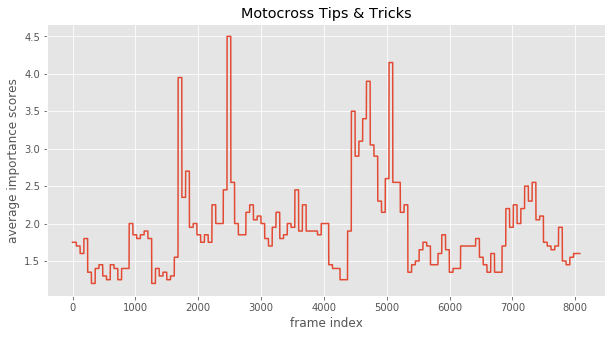

In [73]:
plot_average_importance_scores(y_test_bike_tricks, 'Motocross Tips & Tricks')

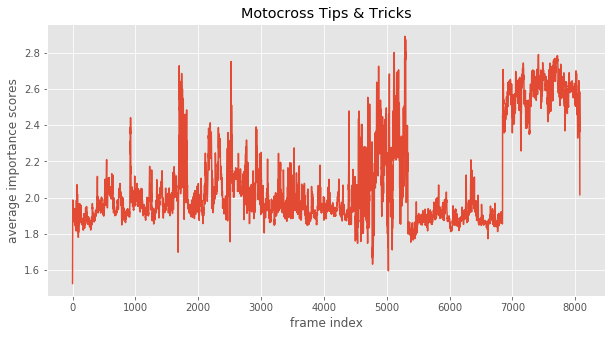

In [74]:
plot_average_importance_scores(bike_tricks_model_predictions, 'Motocross Tips & Tricks')